# <center><font color='green'>Comparative Analysis of ESG vs. Financial Indicators on Predicting Beta.</font></center>

### Part II. Applying Machine Learning Model

### Importing necessary libraries

In [1]:
# data manupulation libraries
import pandas as pd
import numpy as np

# machine learning libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.impute import KNNImputer

# visualization libraries
import graphviz
import matplotlib.pyplot as plt
from IPython.display import display

### Data Preparation

In [2]:
#read extracted financial data from Part I
stocks_data = pd.read_csv('data_raw.csv')
stocks_data.head(5)

,Unnamed: 0,ESG_DISCLOSURE_SCORE,PE_RATIO,PX_TO_BOOK_RATIO,IS_EPS,RETURN_COM_EQY,TOT_DEBT_TO_TOT_EQY,BOOK_VAL_PER_SH,PROF_MARGIN,RETURN_ON_ASSET,Ticker,Industry,MarketCap,ESG_SCORE,BETA_RAW_OVERRIDABLE,OPER_INC_GROWTH
0,2019-12-31,NaN,NaN,NaN,-0.13,NaN,343.8754,-1.5407,-2.3445,NaN,ZIP US Equity,Communication Services,1.884880e+09,NaN,NaN,NaN
1,2020-12-31,NaN,NaN,NaN,0.79,NaN,30.9600,-0.6441,15.0707,38.2091,ZIP US Equity,Communication Services,1.884880e+09,NaN,NaN,NaN
2,2021-12-31,30.3994,1247.0000,12.5480,0.02,NaN,10.7623,1.9876,0.2634,0.6392,ZIP US Equity,Communication Services,1.884880e+09,NaN,NaN,NaN
3,2022-12-31,32.0290,32.1961,59.9565,0.54,46.6592,1956.6946,0.2739,6.7976,11.0483,ZIP US Equity,Communication Services,1.884880e+09,NaN,NaN,NaN
4,2015-12-31,29.8562,16.4769,1.3373,1.89,7.7798,55.0237,25.7318,19.4532,0.9906,RNST US Equity,Financials,1.572284e+09,1.32,-2.2269,16.1573


In [3]:
# most of the missing data is for 2022, therefore we will drop it
# for rest of the missing data from other years we will be using KNN imputer later  
stocks_data.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
stocks_data['Date'] = pd.to_datetime(stocks_data['Date']).dt.strftime('%Y')
stocks_data = stocks_data[stocks_data['Date'] != '2022']

In [4]:
# transform dataset so that we get the most recent financial information for the given dates
new_df = pd.DataFrame()
for stock in stocks_data['Ticker'].unique():
    temp = stocks_data[stocks_data['Ticker'] == stock]
    for year in temp['Date'].unique():
        temp1 = temp[temp['Date'] == year]
        fill_years = temp1.shape[0] - 1
        new_part = temp1.iloc[-1]
        if fill_years >= 0:
            for i in range(fill_years):
                new_part = new_part.fillna(temp1.iloc[i])
        new_df = pd.concat([new_df, new_part], axis=1)

df = new_df.T

In [5]:
# pivotting the dataset so that financial variable for each year is created as a new variable
df_pivot = df.pivot_table(index = ['Ticker','Industry','MarketCap'], columns = 'Date', values = ['ESG_DISCLOSURE_SCORE', 'PE_RATIO', 'PX_TO_BOOK_RATIO','IS_EPS', 'RETURN_COM_EQY', 'TOT_DEBT_TO_TOT_EQY', 'BOOK_VAL_PER_SH','PROF_MARGIN', 'RETURN_ON_ASSET', 'Ticker', 'Industry', 'MarketCap','ESG_SCORE', 'BETA_RAW_OVERRIDABLE', 'OPER_INC_GROWTH']).reset_index()
df_pivot.columns = [f'{col[0]}_{col[1]}' if col[1] != '' else col[0] for col in df_pivot.columns]

In [6]:
# dropping Ticker and Industry information becuase they will not be used for the general model
# Industry information will be used in the next model
df_pivot.drop(columns = ['Ticker','Industry'], inplace=True)

In [7]:
# handling missing values uisjng KNN imputer (machine learning imputer) instead of dropping so that we do not lose observations
imputer = KNNImputer(n_neighbors=5)
imputer.fit(df_pivot)
imputed = imputer.transform(df_pivot)
df_pivot = pd.DataFrame(imputed, columns = df_pivot.columns)

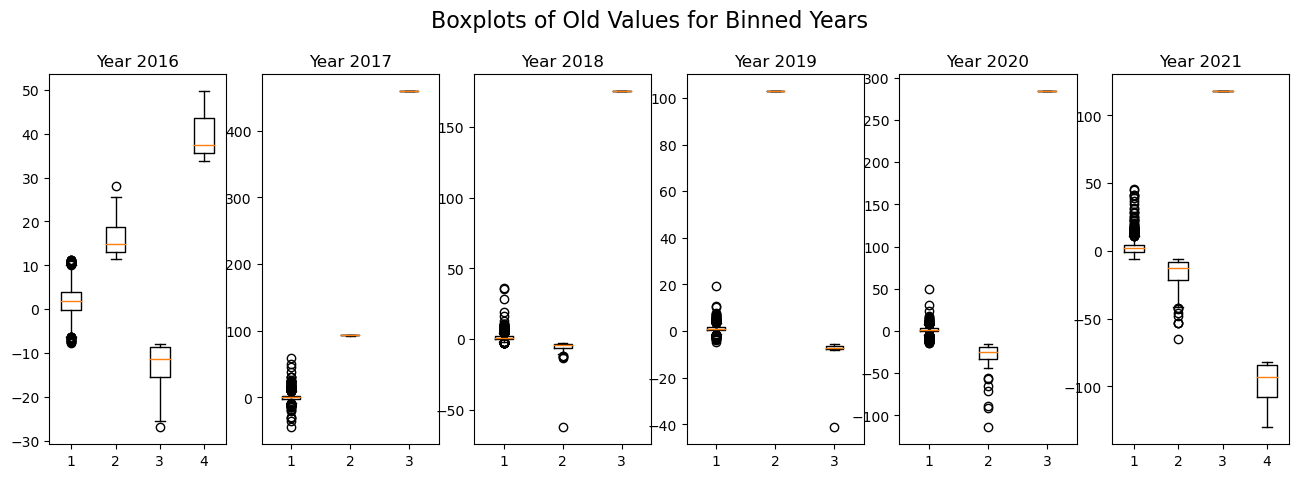

In [8]:
# binning Beta values because we are going to use one of the classification models, not linear
# classification model will be more successful at predicting because it is easir to predict market return class, rather than an exact return value to decimals 
fig, axes = plt.subplots(nrows=1, ncols=len(range(2016, 2022)), figsize=(16, 5))
i = 0

for year in range(2016, 2022):
    column_name = f'BETA_RAW_OVERRIDABLE_{year}'
    old = df_pivot[column_name]
    df_pivot[column_name] = pd.cut(df_pivot[column_name], bins=4, labels=False).astype(str)
    axes[i].boxplot([old[df_pivot[column_name] == bin_val] for bin_val in df_pivot[column_name].unique()])
    axes[i].set_title(f'Year {year}')
    i += 1
    
plt.suptitle('Boxplots of Old Values for Binned Years', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

### Applying a model to a general dataset

In [9]:
# splitting data into training and testing datasets
# creating feature (X) and target (y) values
training_data, testing_data = train_test_split(df_pivot, test_size=0.2, random_state=42)
X_train = training_data.drop(columns = ['BETA_RAW_OVERRIDABLE_2021'], axis=1)
X_test = testing_data.drop(columns = ['BETA_RAW_OVERRIDABLE_2021'], axis=1)
y_train = training_data['BETA_RAW_OVERRIDABLE_2021']
y_test = testing_data['BETA_RAW_OVERRIDABLE_2021']

In [10]:
# creating a random forest classifier model
# feeding it with data prepared above and assessing it with r-squared
model = RandomForestClassifier()
model.fit(X_train, y_train)
test_r2 = model.score(X_test, y_test)
print(f"Testing R-squared: {test_r2:.2f}")

Testing R-squared: 0.92


Text(0.5, 1.0, 'General Feature Importance')

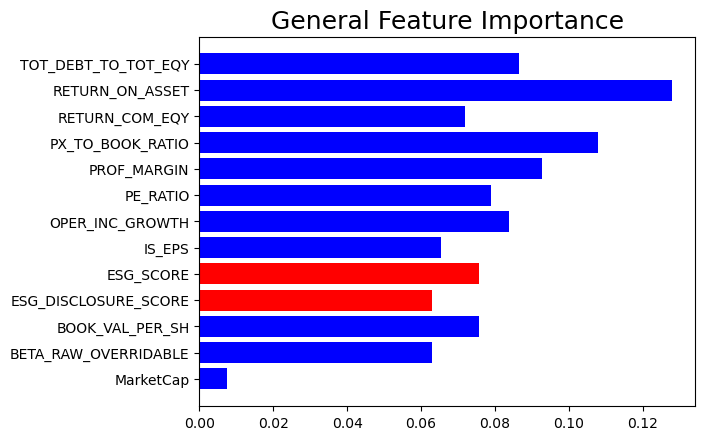

In [11]:
# retriving infromation about feature importance and summarizing it by neglecting date infromation
feature_names = X_train.columns
feature_importances = model.feature_importances_
            
importance = pd.DataFrame([feature_names, feature_importances]).T
prefixes = importance[0].apply(lambda x: x.rsplit('_', 1)[0]).unique()

summed_data = {'Financial_Ratio': [], 'Total_Value': []}

for prefix in prefixes:
    cols_to_sum = [col for col in importance[0] if col.startswith(prefix)]
    summed_value = importance.loc[importance[0].isin(cols_to_sum), 1].sum()
    summed_data['Financial_Ratio'].append(prefix)
    summed_data['Total_Value'].append(summed_value)  
    
plt.barh(summed_data['Financial_Ratio'], summed_data['Total_Value'], color = np.where(np.isin(summed_data['Financial_Ratio'], ['ESG_SCORE', 'ESG_DISCLOSURE_SCORE']), 'red', 'blue'))
plt.title('General Feature Importance', fontsize = 18)

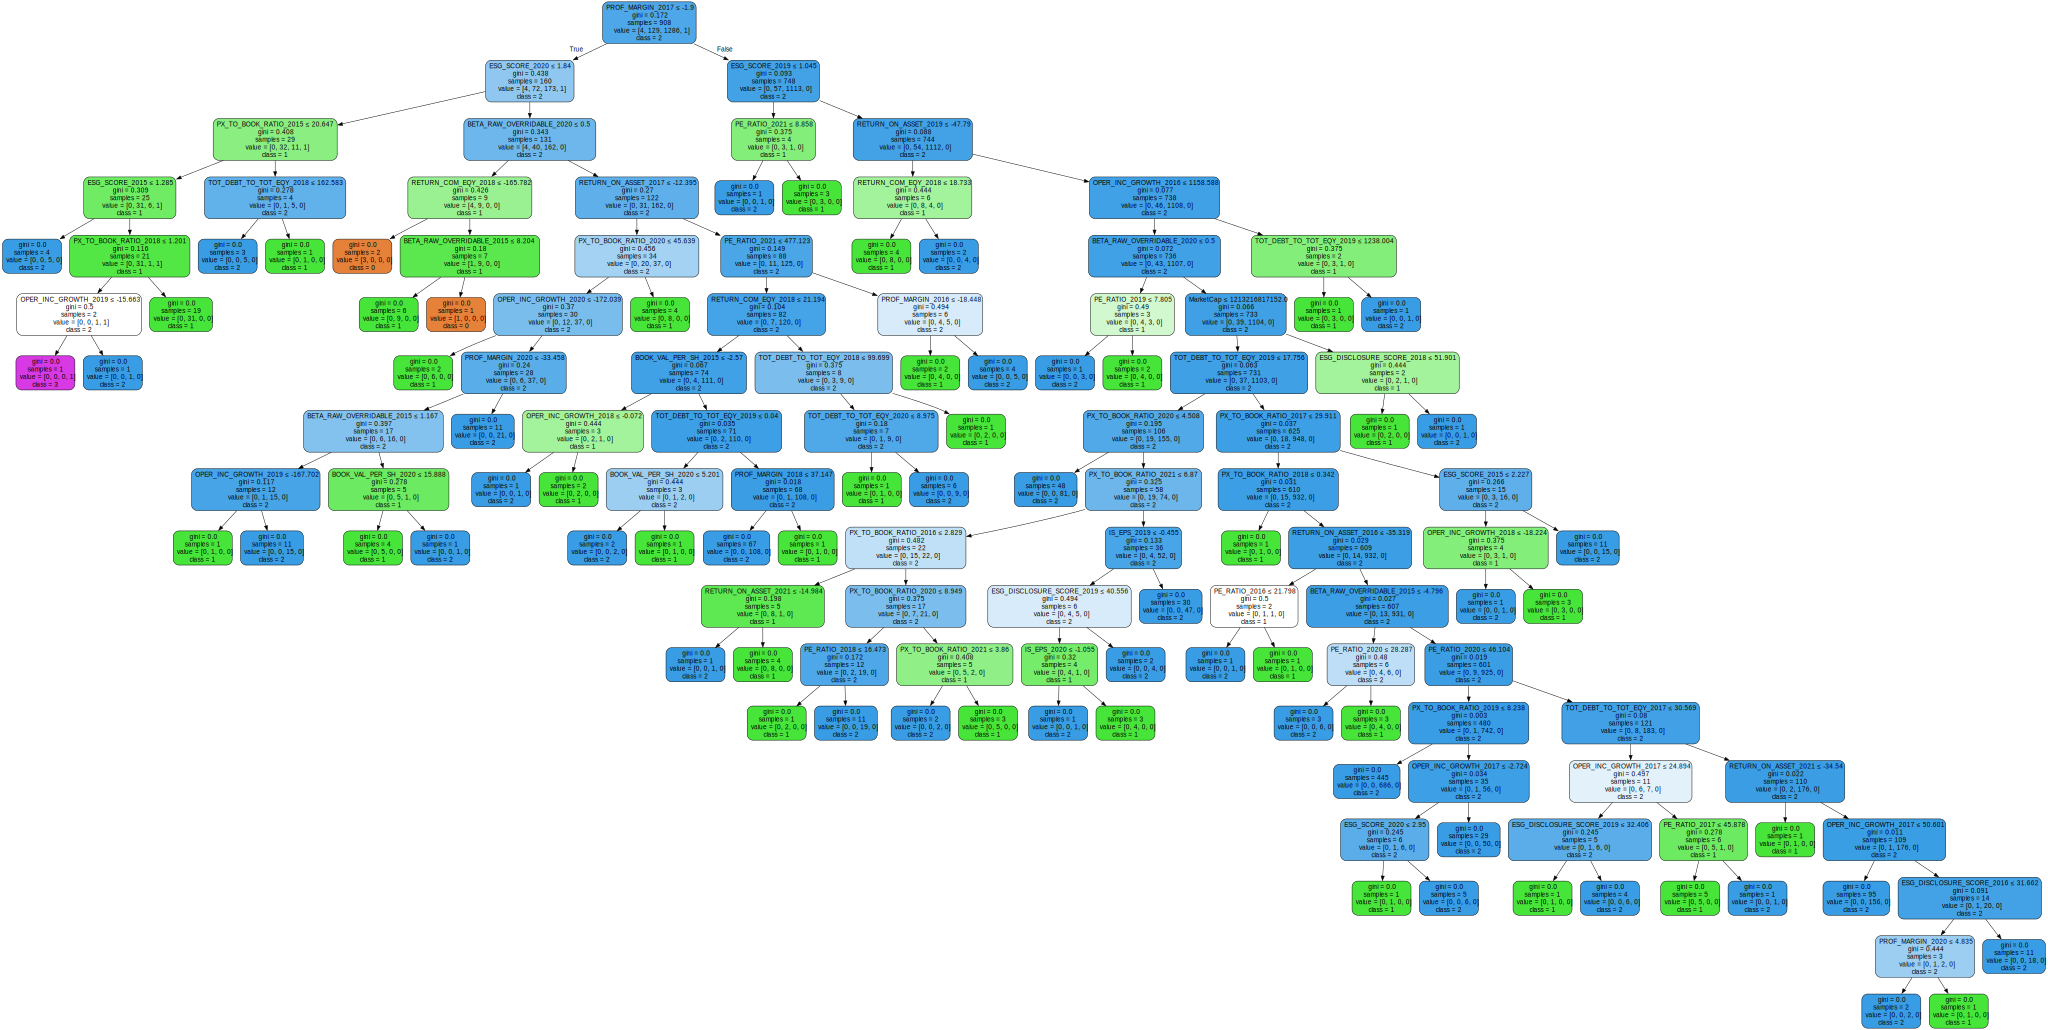

In [12]:
# visualizing one of the trees of the forest model
decision_tree = model.estimators_[0]
dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, class_names=np.unique(y_train).astype(str), filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render(f'tree_general', view=False, format='png')
display(graph)

### Applying a model by industry and market type (bullish vs bearish)

In [13]:
#importing bloomberg infromation on S&P500 index market performance (bullish vs bearish performance) based on 11 industries (GISC sectors)
spx = pd.read_csv('sp500_ind_performance.csv', encoding= 'unicode_escape')
spx['Date'] = pd.to_datetime(spx['Date']).dt.strftime('%Y').astype(str)
spx = spx.set_index('Date').T
length = spx.shape[1]-1
for i in range(length):
    spx[int(spx.columns[i])] = spx[spx.columns[i]]-spx[spx.columns[i+1]]
    spx[int(spx.columns[i])] = np.where(spx[int(spx.columns[i])]>0, 'bull', 'bear')

spx.drop(columns=[spx.columns[length],'2023','2022','2021', '2020', '2019','2018','2017','2016', '2015','2014'], inplace=True)
spx.reset_index(inplace=True)
spx['Industry'] = spx['index'].replace({'S5INFT Index':'Information Technology', 'S5FINL Index' : 'Financials', 'S5HLTH Index':'Health Care', 'S5COND Index':'Consumer Discretionary', 'S5TELS Index':'Communication Services', 'S5INDU Index':'Industrials', 'S5CONS Index':'Consumer Staples', 'S5ENRS Index':'Energy', 'S5UTIL Index':'Utilities', 'S5RLST Index':'Real Estate', 'S5MATR Index':'Materials'})
spx = spx.drop(columns=['index'], axis=1)
spx

Date,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,Industry
0,bull,bear,bull,bull,bull,bear,bull,bull,bear,bull,SPX Index
1,bull,bear,bull,bull,bull,bear,bull,bull,bull,bull,Information Technology
2,bear,bear,bull,bear,bull,bear,bull,bull,bear,bull,Financials
3,bear,bear,bull,bull,bull,bull,bull,bear,bull,bull,Health Care
4,bull,bear,bull,bull,bull,bear,bull,bull,bull,bull,Consumer Discretionary
5,bull,bear,bull,bull,bull,bear,bear,bull,bear,bear,Communication Services
6,bull,bear,bull,bull,bull,bear,bull,bull,bear,bull,Industrials
7,bull,bear,bull,bull,bull,bear,bull,bull,bull,bull,Consumer Staples
8,bear,bull,bull,bear,bull,bear,bear,bull,bear,bear,Energy
9,bear,bear,bull,bear,bull,bull,bull,bull,bear,bull,Utilities


In [14]:
# applying S&P500 industries performance information to our initial dataset
df['MarketType'] = df.apply(lambda row: spx.loc[spx['Industry'] == row['Industry'], int(row['Date'])].values[0], axis=1)
df[['Date', 'Ticker', 'MarketType']].head(5)

,Date,Ticker,MarketType
0,2019,ZIP US Equity,bull
1,2020,ZIP US Equity,bull
2,2021,ZIP US Equity,bull
4,2015,RNST US Equity,bear
5,2016,RNST US Equity,bull


In [15]:
# breaking our initial dataset into bearish and bullish datasets
df_bull = df[df['MarketType']=='bull']
df_bear = df[df['MarketType']=='bear']
dfs = df_bull, df_bear

Average R-squared for bullish market: 0.91
Average R-squared for bearish market: 0.70


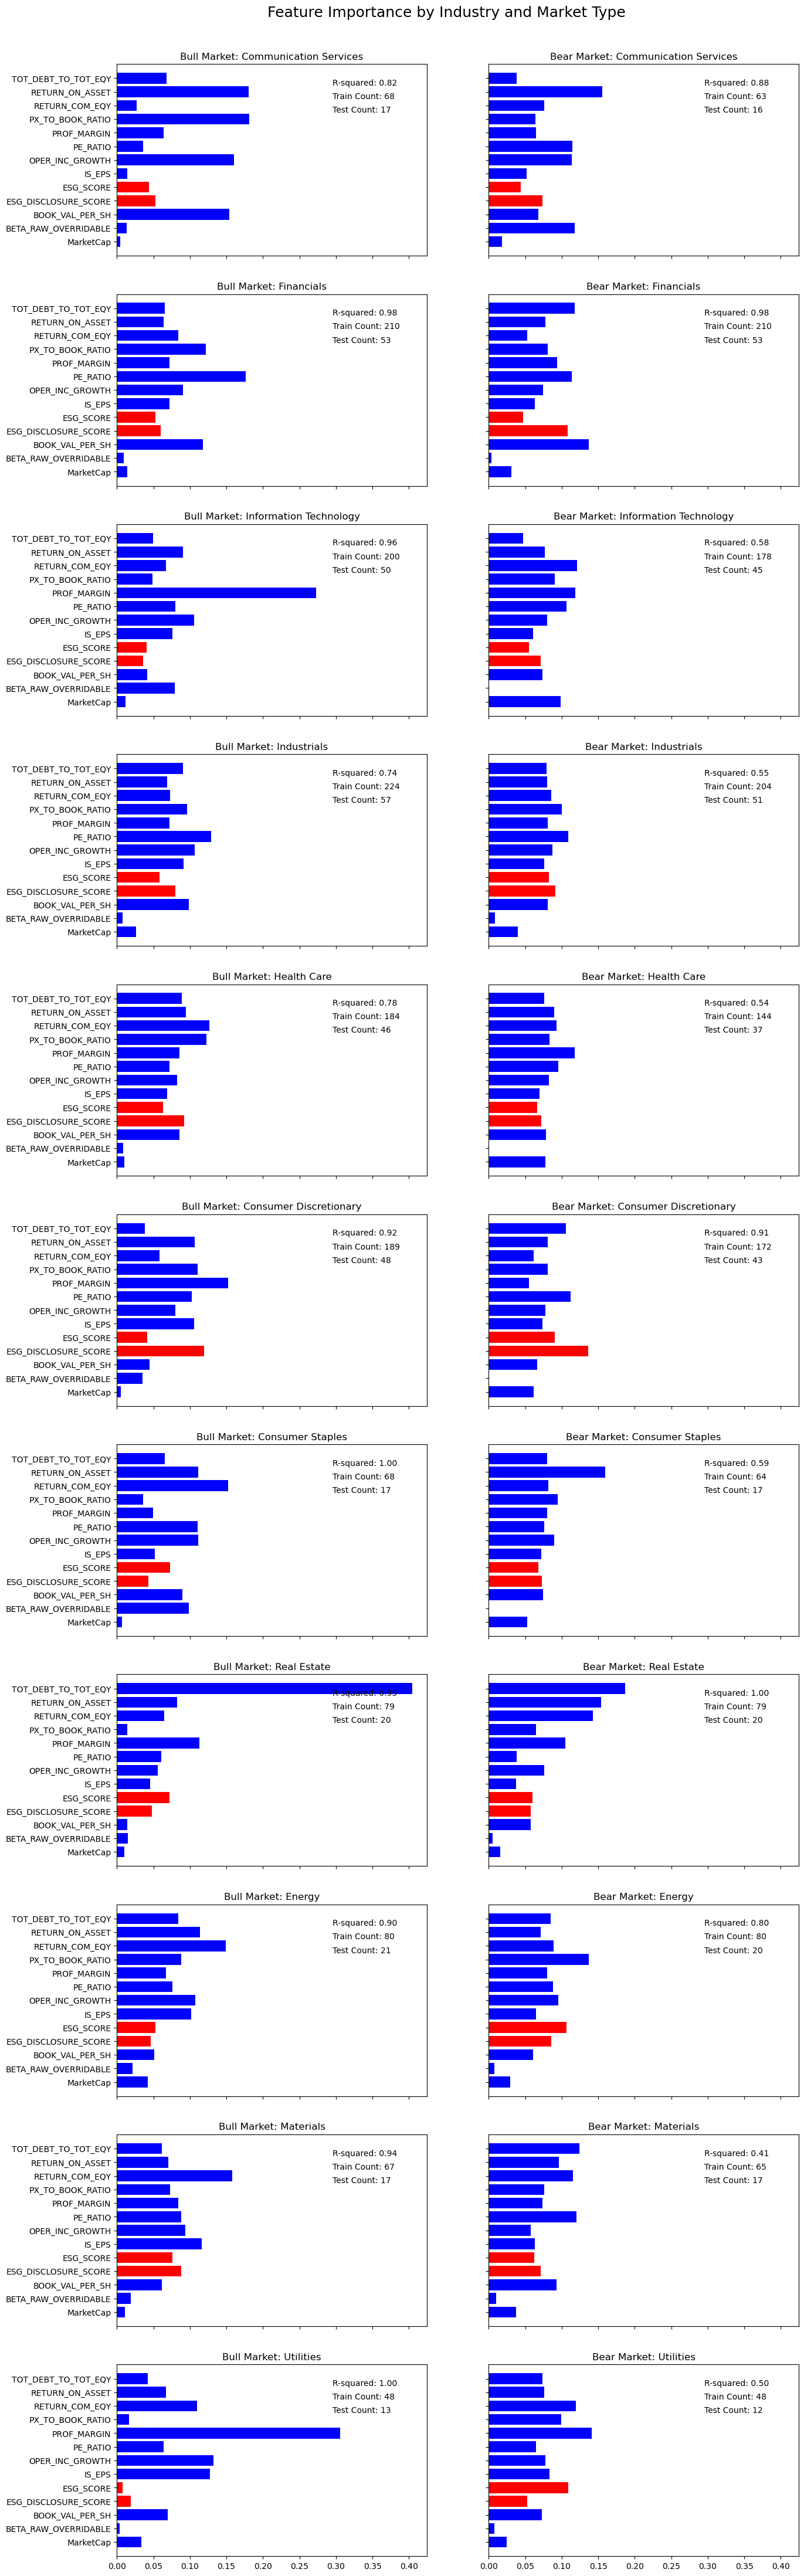

In [16]:
# filtering, pivotting, imputing, applying a model for each market type and each industry
# visualizing feature importance information for each of the models
arr = []
markettype_idx = -1

fig,axs = plt.subplots(11, 2, sharex = True, sharey = True, figsize = (15,50))
plt.suptitle('Feature Importance by Industry and Market Type', fontsize = 18)
plt.subplots_adjust(top=0.96)

for df_type in dfs:
    markettype_idx += 1
    industry_idx = - 1
    
    for industry in df['Industry'].unique():
        industry_idx += 1
        df_ind = df_type[df_type['Industry'] == industry]
        dates = df_ind['Date'].unique()        
        df_ind_pivot = df_ind.pivot_table(index = ['MarketCap'], columns = 'Date', values = ['ESG_DISCLOSURE_SCORE', 'PE_RATIO', 'PX_TO_BOOK_RATIO','IS_EPS', 'RETURN_COM_EQY', 'TOT_DEBT_TO_TOT_EQY', 'BOOK_VAL_PER_SH','PROF_MARGIN', 'RETURN_ON_ASSET', 'MarketCap','ESG_SCORE', 'BETA_RAW_OVERRIDABLE', 'OPER_INC_GROWTH', 'Ticker', 'Industry']).reset_index()
        df_ind_pivot.columns = [f'{col[0]}_{col[1]}' if col[1] != '' else col[0] for col in df_ind_pivot.columns]
        
        imputer = KNNImputer(n_neighbors=3)
        imputer.fit(df_ind_pivot)
        imputed = imputer.transform(df_ind_pivot)
        df_ind_pivot = pd.DataFrame(imputed, columns=df_ind_pivot.columns)
        
        for year in dates:
            column_name = f'BETA_RAW_OVERRIDABLE_{year}'
            df_ind_pivot[column_name] = pd.cut(df_ind_pivot[column_name], bins=3, labels=False)

        if len(df_ind_pivot)>=2:
            training_data, testing_data = train_test_split(df_ind_pivot, test_size=0.2, random_state=42)
            
            X_train = training_data.drop(columns = [f'BETA_RAW_OVERRIDABLE_{max(dates)}'], axis=1)
            X_test = testing_data.drop(columns = [f'BETA_RAW_OVERRIDABLE_{max(dates)}'], axis=1)
            y_train = training_data[f'BETA_RAW_OVERRIDABLE_{max(dates)}']
            y_test = testing_data[f'BETA_RAW_OVERRIDABLE_{max(dates)}']
            
            model = RandomForestClassifier()
            model.fit(X_train, y_train)
            test_r2 = model.score(X_test, y_test)
            arr.append(test_r2)
            
            feature_names = X_train.columns
            feature_importances = model.feature_importances_
            
            importance = pd.DataFrame([feature_names, feature_importances]).T
            prefixes = importance[0].apply(lambda x: x.rsplit('_', 1)[0]).unique()

            summed_data = {'Financial_Ratio': [], 'Total_Value': []}

            for prefix in prefixes:
                cols_to_sum = [col for col in importance[0] if col.startswith(prefix)]
                summed_value = importance.loc[importance[0].isin(cols_to_sum), 1].sum()
                summed_data['Financial_Ratio'].append(prefix)
                summed_data['Total_Value'].append(summed_value) 
                
            idxs = industry_idx, markettype_idx
            axs[idxs].barh(summed_data['Financial_Ratio'], summed_data['Total_Value'], color = np.where(np.isin(summed_data['Financial_Ratio'], ['ESG_SCORE', 'ESG_DISCLOSURE_SCORE']), 'red', 'blue'))
            
            if markettype_idx == 0:
                markettype = 'Bull Market'
            else:
                markettype = 'Bear Market'
                
            axs[idxs].set_title(f'{markettype}: {industry}')
            axs[idxs].text(0.295, 11.5, f'R-squared: {test_r2:.2f}')
            axs[idxs].text(0.295, 10.5, f'Train Count: {len(training_data)}')
            axs[idxs].text(0.295, 9.5, f'Test Count: {len(testing_data)}')

print(f'Average R-squared for bullish market: {np.mean(arr[:11]):.2f}')
print(f'Average R-squared for bearish market: {np.mean(arr[-11:]):.2f}')

plt.show()